In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
print("Setup complete")

Setup complete


Average measurement error: 2.35 meters
Average Kalman filter error: 0.75 meters


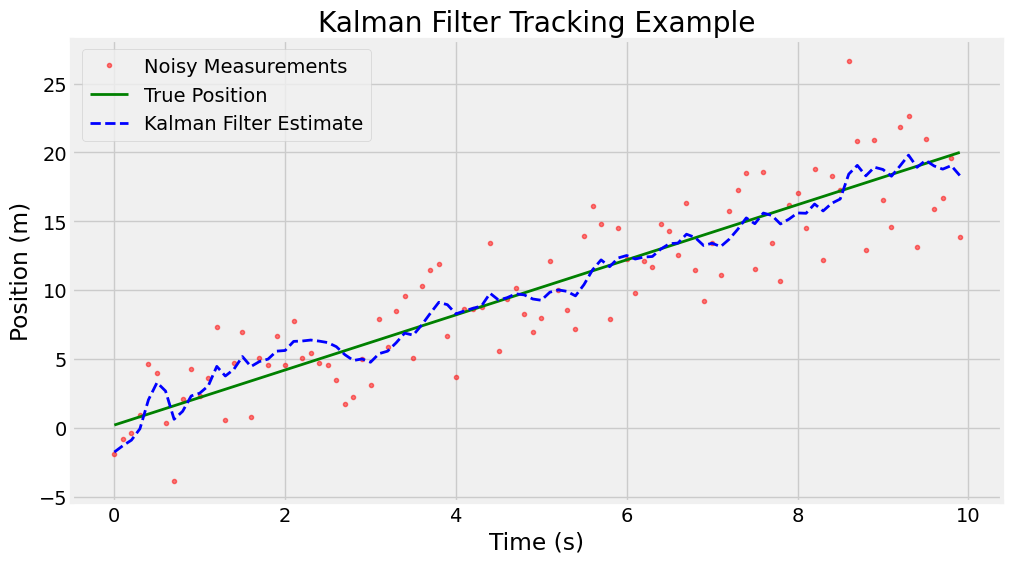

In [3]:


# Generate sample data: tracking an object moving with constant velocity + noise
def generate_measurements(n_steps):
    # True state: [position, velocity]
    true_state = np.array([0., 2.])  # Starting at position 0 with velocity 2 m/s
    
    measurements = []
    true_positions = []
    
    dt = 0.1  # Time step of 0.1 seconds
    measurement_std = 3.0  # Standard deviation of measurement noise
    
    for _ in range(n_steps):
        # Update true state (constant velocity motion)
        true_state[0] += true_state[1] * dt
        
        # Generate noisy measurement of position
        measurement = true_state[0] + np.random.normal(0, measurement_std)
        
        measurements.append(measurement)
        true_positions.append(true_state[0])
    
    return np.array(measurements), np.array(true_positions)

class KalmanFilter:
    def __init__(self, dt):
        # State transition matrix
        self.F = np.array([[1, dt],
                          [0, 1]])
        
        # Measurement matrix (we only measure position)
        self.H = np.array([[1, 0]])
        
        # Initial state covariance
        self.P = np.array([[100, 0],
                          [0, 100]])
        
        # Process noise covariance
        self.Q = np.array([[0.1, 0],
                          [0, 0.1]])
        
        # Measurement noise covariance
        self.R = np.array([[9.0]])  # Variance of measurement noise
        
        # Initial state estimate
        self.x = np.array([[0],
                          [0]])
    
    def predict(self):
        # Predict next state
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        
        return self.x[0, 0]
    
    def update(self, measurement):
        # Compute Kalman Gain
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # Update state estimate
        y = measurement - self.H @ self.x
        self.x = self.x + K @ y
        
        # Update error covariance
        self.P = (np.eye(2) - K @ self.H) @ self.P
        
        return self.x[0, 0]

# Generate sample data
n_steps = 100
measurements, true_positions = generate_measurements(n_steps)

# Apply Kalman filter
kf = KalmanFilter(dt=0.1)
filtered_positions = []

for measurement in measurements:
    kf.predict()
    filtered_pos = kf.update(measurement)
    filtered_positions.append(filtered_pos)

# Plotting
plt.figure(figsize=(12, 6))
plt.style.use('fivethirtyeight')

t = np.arange(n_steps) * 0.1  # Time points

plt.plot(t, measurements, 'r.', label='Noisy Measurements', alpha=0.5)
plt.plot(t, true_positions, 'g-', label='True Position', linewidth=2)
plt.plot(t, filtered_positions, 'b--', label='Kalman Filter Estimate', linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Kalman Filter Tracking Example')
plt.legend()
plt.grid(True)

# Calculate and print error metrics
measurement_error = np.mean(np.abs(measurements - true_positions))
kalman_error = np.mean(np.abs(filtered_positions - true_positions))

print(f"Average measurement error: {measurement_error:.2f} meters")
print(f"Average Kalman filter error: {kalman_error:.2f} meters")

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/pyplot.py'>

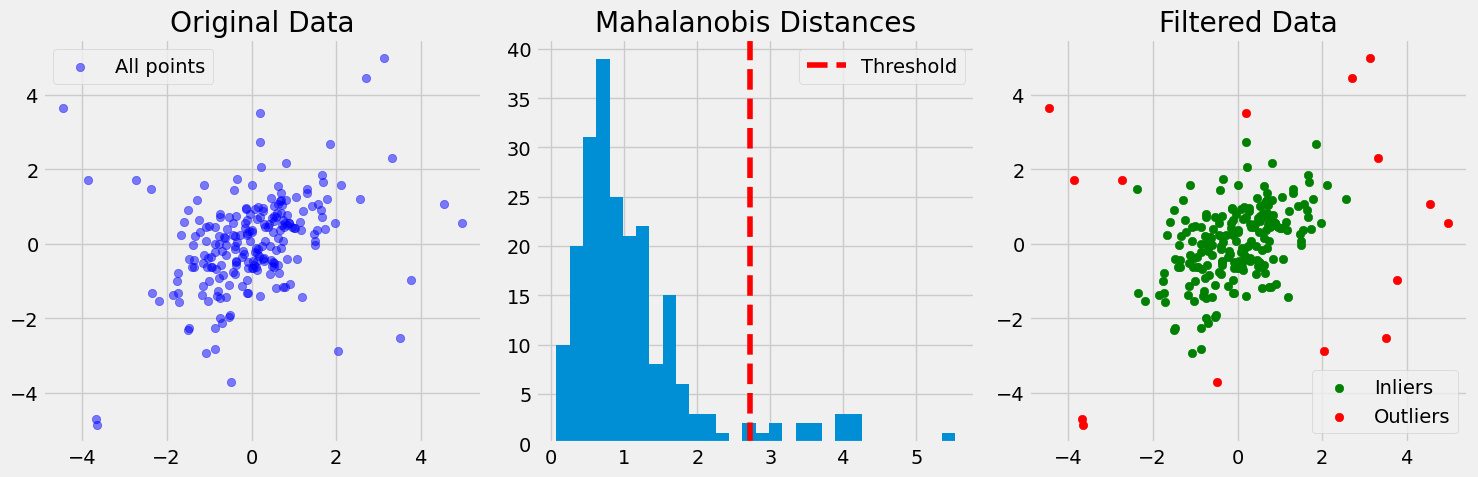

In [4]:
# Using Mahalanobis Filter
class MahalanobisFilter:
    def __init__(self, threshold=0.975):
        self.mean = None
        self.cov = None
        self.threshold = threshold
    
    def fit(self, X):
        """Compute mean and covariance matrix of training data"""
        self.mean = np.mean(X, axis=0)
        self.cov = np.cov(X.T)
        self.cov_inv = np.linalg.inv(self.cov)
        
    def mahalanobis_distance(self, x):
        """Calculate Mahalanobis distance for a point"""
        diff = x - self.mean
        return np.sqrt(diff.dot(self.cov_inv).dot(diff))
    
    def filter(self, X):
        """Filter outliers using Mahalanobis distance"""
        distances = np.array([self.mahalanobis_distance(x) for x in X])
        threshold = np.sqrt(chi2.ppf(self.threshold, df=X.shape[1]))
        return distances <= threshold

class ParticleFilter:
    def __init__(self, n_particles=1000):
        self.n_particles = n_particles
        
    def initialize(self, initial_state, noise_std):
        """Initialize particles around initial state"""
        self.particles = initial_state + np.random.normal(0, noise_std, 
                                                        size=(self.n_particles, len(initial_state)))
        self.weights = np.ones(self.n_particles) / self.n_particles
        
    def predict(self, motion_model, noise_std):
        """Move particles according to motion model"""
        self.particles = motion_model(self.particles) + \
                        np.random.normal(0, noise_std, size=self.particles.shape)
    
    def update(self, measurement, measurement_std):
        """Update weights based on measurement"""
        # Calculate likelihood of each particle
        likelihoods = np.exp(-0.5 * ((self.particles - measurement) / measurement_std) ** 2) / \
                     (np.sqrt(2 * np.pi) * measurement_std)
        
        # Update weights
        self.weights *= np.prod(likelihoods, axis=1)
        self.weights /= np.sum(self.weights)  # Normalize
        
        # Resample if effective particle size is too low
        if 1 / np.sum(self.weights ** 2) < self.n_particles / 2:
            self.resample()
    
    def resample(self):
        """Resample particles based on weights"""
        indices = np.random.choice(self.n_particles, size=self.n_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.n_particles) / self.n_particles
    
    def estimate(self):
        """Get weighted average of particles"""
        return np.average(self.particles, weights=self.weights, axis=0)

# Example usage and comparison
def compare_filters():
    # Generate sample data with outliers
    np.random.seed(42)
    n_samples = 200
    
    # Generate clean data
    clean_data = np.random.multivariate_normal(
        mean=[0, 0],
        cov=[[1, 0.5], [0.5, 1]],
        size=n_samples
    )
    
    # Add outliers
    outliers = np.random.uniform(-5, 5, size=(20, 2))
    data = np.vstack([clean_data, outliers])
    
    # Apply Mahalanobis filter
    mfilter = MahalanobisFilter(threshold=0.975)
    mfilter.fit(data)
    mask = mfilter.filter(data)
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    # Original data
    plt.subplot(131)
    plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.5, label='All points')
    plt.title('Original Data')
    plt.legend()
    
    # Mahalanobis distances
    plt.subplot(132)
    distances = np.array([mfilter.mahalanobis_distance(x) for x in data])
    plt.hist(distances, bins=30)
    threshold = np.sqrt(chi2.ppf(0.975, df=2))
    plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Mahalanobis Distances')
    plt.legend()
    
    # Filtered data
    plt.subplot(133)
    plt.scatter(data[mask, 0], data[mask, 1], c='green', label='Inliers')
    plt.scatter(data[~mask, 0], data[~mask, 1], c='red', label='Outliers')
    plt.title('Filtered Data')
    plt.legend()
    
    plt.tight_layout()
    return plt

# Run comparison
plt.close('all')  # Clear any existing plots
compare_filters()